In [23]:
# Colab Setup (Run this first)

In [24]:
!pip install litebird_sim rich

/bin/bash: /data83/LiteBIRD/mgomes/lbs/venv/bin/pip: /automnt/data83/LiteBIRD/mgomes/litebird_sim/venv/bin/python3: bad interpreter: No such file or directory


To run this notebook, you have several options:

-   If you are running this under Binder, you should already be set!
-   If you are running this under Google Colab, be sure to run the cell with `!pip install…` that is right above the title.
-   If you are running this locally, you should first create and activate a new virtual environment with the commands

    ```
    python -m venv ./my_venv
    source ./my_venv/bin/activate
    ```

    (you can use Conda environments, if you prefer) and install Jupyter and litebird_sim in it:

    ```
    pip install jupyter litebird_sim
    ```

    If you have a local copy of the `litebird_sim` repository cloned from <https://github.com/litebird/litebird_sim> (e.g., because you're part of the Simulation Team!), you can use a _development install_ instead:

    ```
    cd /my/local/copy/litebird_sim
    pip install -e .
    ```


## Import Modules

In [25]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import brahmap

import litebird_sim as lbs
from litebird_sim.hwp_harmonics import mueller_interpolation
from litebird_sim.coordinates import CoordinateSystem

## Define Parameters

In [26]:
start_time = 0
time_span_s = 365 * 24 * 3600
nside = 128
sampling = 1
hwp_radpsec = lbs.IdealHWP(
    46 * 2 * np.pi / 60,
).ang_speed_radpsec

lbs.PTEP_IMO_LOCATION = "schema.json"
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
imo_version = "IMo_vReformationPlan_Option2M"

## Create Simulation

In [27]:
sim = lbs.Simulation(
    start_time=start_time, duration_s=time_span_s, random_seed=0, imo=imo
)


## Define Frequency Channel

In [28]:
channel = "MF1_140"

channelinfo = lbs.FreqChannelInfo.from_imo(
    url=f"/releases/{imo_version}/LMHFT/{channel}/channel_info",
    imo=imo,
)

## Define Scanning Strategy

In [29]:
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/Observation/Scanning_Strategy"
)

## Define Instrument

In [30]:
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/LMHFT/instrument_info",
    )
)

## Set HWP (with Mueller formalism)

In [31]:
sim.set_hwp(lbs.NonIdealHWP(hwp_radpsec, harmonic_expansion=True, calculus=lbs.Calc.MUELLER))

## Define Detectors

In [32]:
det = lbs.DetectorInfo.from_imo(
    url=f"/releases/{imo_version}/LMHFT/{channel}/{channelinfo.detector_names[0]}/detector_info",
    imo=imo,
)

theta = det.pointing_theta_phi_psi_deg[0]

det.mueller_hwp = {
    "0f": np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]], dtype=np.float64),
    "2f": np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]], dtype=np.float64),
    "4f": np.array(
        [
            [0, 0, 0],
            [mueller_interpolation(theta, "4f", 1, 0), 1, 1],
            [mueller_interpolation(theta, "4f", 2, 0), 1, 1],
        ],
        dtype=np.float64,
    ),
}
"""
det.jones_hwp = {
    "0f": np.array([[0, 0], [0, 0]], dtype=np.float64),
    "2f": np.array([[0, 0], [0, 0]], dtype=np.float64),
}"""

[2025-10-23 14:04:55,691 WARNING MPI#0000] Detector '999_007_000_XX_140_T': mueller_hwp is not a 4x4 numpy array (found type <class 'dict'>, shape None)


'\ndet.jones_hwp = {\n    "0f": np.array([[0, 0], [0, 0]], dtype=np.float64),\n    "2f": np.array([[0, 0], [0, 0]], dtype=np.float64),\n}'

## Create Observations and Prepare Pointings

In [33]:
(obs,) = sim.create_observations(
    detectors=[det],
)

sim.prepare_pointings(append_to_report=False)

## Generate Input Sky Maps

In [34]:
mbs_params = lbs.MbsParameters(
    make_cmb=True,
    seed_cmb=1234,
    make_noise=False,
    make_dipole=True,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_dust_0", "pysm_freefree_1"],
    gaussian_smooth=True,
    bandpass_int=False,
    maps_in_ecliptic=True,
    nside=nside,
    units="K_CMB",
)

mbs = lbs.Mbs(simulation=sim, parameters=mbs_params, channel_list=[channelinfo])

input_maps = mbs.run_all()[0]["MF1_140"]

# add monopole
# input_maps[0] += 2.7255


[2025-10-23 14:04:58,486 INFO MPI#0000] generating and saving cmb simulations
[2025-10-23 14:04:58,521 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-10-23 14:04:58,522 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2025-10-23 14:04:58,822 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-10-23 14:04:58,823 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2025-10-23 14:04:58,882 INFO MPI#0000] Sigma is 6.878626 arcmin (0.002001 rad) 
[2025-10-23 14:04:58,883 INFO MPI#0000] -> fwhm is 16.197927 arcmin
[2025-10-23 14:04:58,886 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-10-23 14:04:58,887 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2025-10-23 14:04:58,905 INFO MPI#0000] generating and saving fg simulations
[2025-10-23 14:04:58,906 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2025-10-23 14:04:58,910 INFO MPI#0000] NSIDE = 512
[2025-10-23 14:04:58,910 INFO MPI#0000] ORDERING = RING in fits file
[2025-10-23 14:04:58,911 

## Generate HwpSys object and Set its parameters

## Fill TOD and perform Mapmaking on-the-fly

In [35]:
output_map = lbs.scan_map_in_observations(
    maps=input_maps,
    observations=[obs],
    input_map_in_galactic=False,
)

In [36]:
gls_params = brahmap.LBSimGLSParameters(
    solver_type = brahmap.SolverType.IQU,
    output_coordinate_system = CoordinateSystem.Ecliptic,
)

brahmap_result = lbs.make_brahmap_gls_map(
    nside=nside,
    observations=[obs],
    hwp=sim.hwp,
    pointings_dtype=np.float64,
    gls_params=gls_params,
)


-------------------------- ProcessTimeSamples Summary --------------------------
Processed 599184000 time samples for npix=196608
Found 0 pathological pixels on the map
Map-maker will take into account only 196608 pixels
--------------------------------------------------------------------------------
conssverged in 1 iterations


## Show Leakage Maps

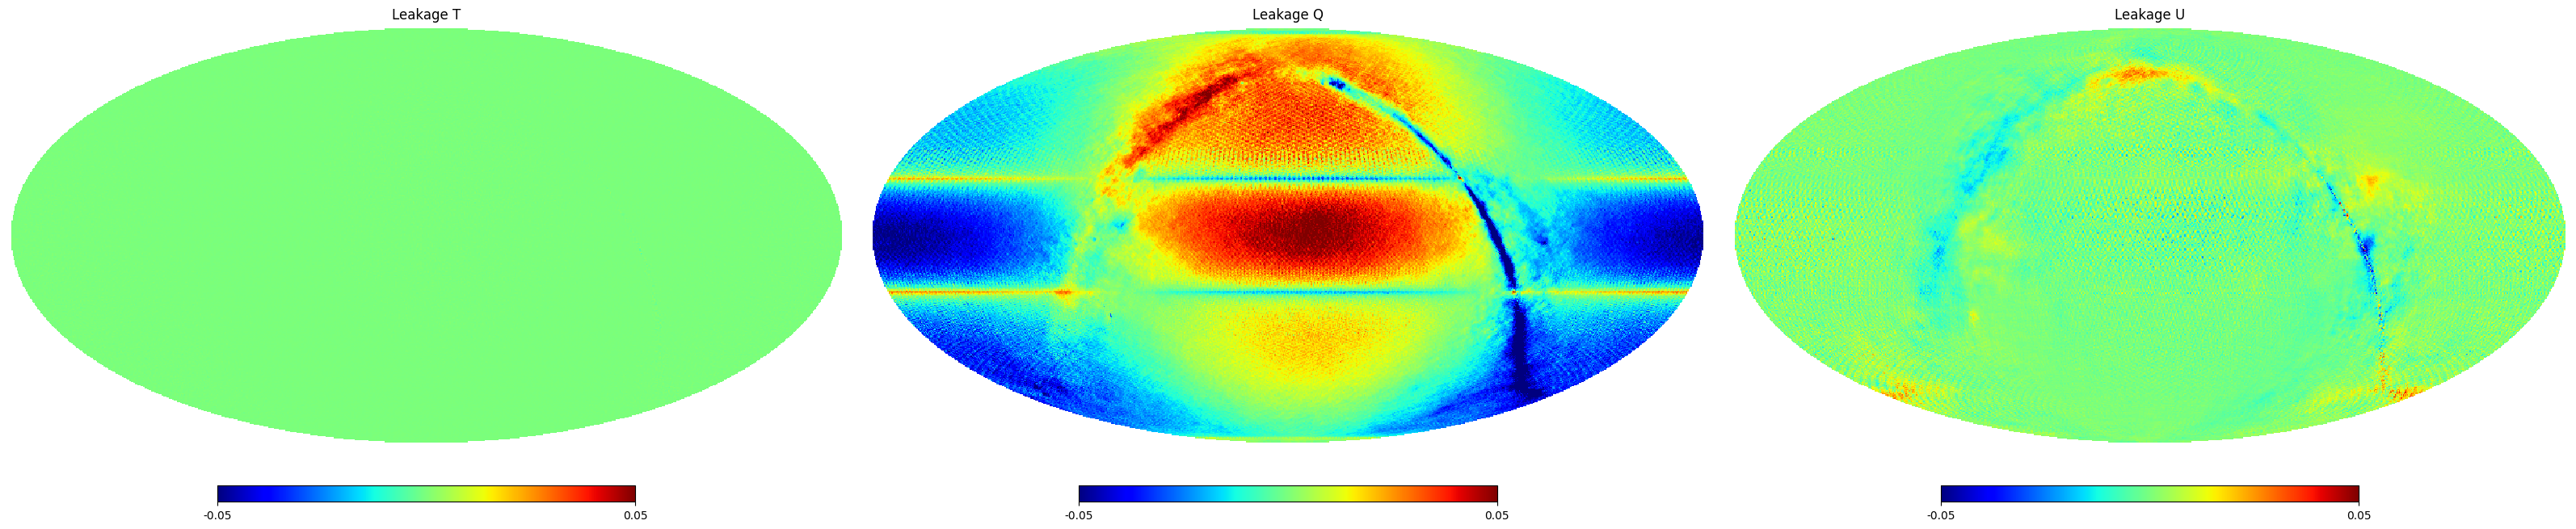

In [37]:
plt.figure(figsize=(32, 10))
stokes_parameters = ["T", "Q", "U"]
for i in range(3):
    hp.mollview(
        (brahmap_result.GLS_maps[i] - input_maps[i]) * 1e6,
        cmap="jet",
        min=-0.05,
        max=0.05,
        sub=(1, 3, i + 1),
        title="Leakage " + stokes_parameters[i],
    )